In [2]:
# Step 1: Initial Imports and Setup (from model.ipynb)
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
# For inline plotting in notebooks
# %matplotlib inline

image_size = 150
channels = 1 # Assuming grayscale images based on your flow_from_directory color_mode

In [3]:
# Step 2: Data Preparation (from model.ipynb)
# Data augmentation and loading for training
training_data = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 10,
    shear_range=0.1,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_gen = training_data.flow_from_directory(
    'Dataset_Split/train',
    target_size = (image_size,image_size),
    batch_size = 32,
    class_mode = 'sparse',
    color_mode = "grayscale",
)

# Data augmentation and loading for validation
val_data = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range= 10,
)

val_gen = val_data.flow_from_directory(
    'Dataset_Split/val',
    target_size=(image_size,image_size),
    batch_size=32,
    class_mode='sparse',
    color_mode = "grayscale",
)

# Data augmentation and loading for testing
test_data = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10
)
test_gen = test_data.flow_from_directory(
    'Dataset_Split/test',
    target_size=(image_size, image_size),
    batch_size = 32,
    class_mode='sparse',
    color_mode = "grayscale",
)

print("Class indices:", train_gen.class_indices)

class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

Found 3372 images belonging to 4 classes.
Found 419 images belonging to 4 classes.
Found 426 images belonging to 4 classes.
Class indices: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}
Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [4]:
# Step 3: Build Model (from model.ipynb)
input_shape = (image_size, image_size, channels)
# Determine the number of classes from your training generator
class_labels = len(train_gen.class_indices)

model = models.Sequential([
    layers.InputLayer(input_shape = input_shape),
    # First convolutional block
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    # Second convolutional block
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    # Third convolutional block
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Fourth convolutional block
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    # Flatten layer to transition from convolutional to dense layers
    layers.Flatten(),
    # Dense hidden layer
    layers.Dense(64, activation= 'relu'),
    # Output layer
    layers.Dense(class_labels, activation='softmax'),
])

In [6]:
# Step 4: Model Summary and Compile (from model.ipynb)
model.summary()

model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print(f"Number of validation batches: {len(val_gen)}")
print(f"Number of training batches: {len(train_gen)}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,700 (1.12 MB)

 Trainable params: 293,700 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Number of validation batches: 14
Number of training batches: 106


In [7]:
# Step 5: Receptive Field Calculation (from Visualising_CNN.ipynb)
# This function calculates the receptive field for a sequence of convolutional and pooling layers.
# 'layers' is a list of tuples, where each tuple is (kernel_size, stride) for a layer.
def compute_receptive_field(layers):
    rf = 1 # Initial receptive field of the last layer (a single pixel neuron)
    jump = 1 # How many pixels in the input correspond to a 1-pixel step in current layer
    for k, s in reversed(layers):
        rf = rf + (k - 1) * jump
        jump = jump * s # updates the effective stride to account for this layer’s stride.
    return rf

# Define the layers of your 'model' for receptive field calculation.
# Extract kernel sizes and strides from your model's Conv2D and MaxPooling2D layers.
# Assuming your model layers are: Conv2D, MaxPool2D, Conv2D, MaxPool2D, Conv2D, MaxPool2D, Conv2D, MaxPool2D
# Note: For simplicity, we are manually extracting these. A more robust solution might iterate
# through model.layers and check their types.
# (kernel_size, stride) for Conv2D, (pool_size, stride) for MaxPooling2D
# For MaxPooling2D, pool_size is the kernel, and strides default to pool_size if not specified.
# Your model has:
# Conv2D(32, (3,3), stride=1) -> kernel=3, stride=1
# MaxPooling2D((2,2)) -> kernel=2, stride=2 (default)
# Conv2D(64, (3,3), stride=1) -> kernel=3, stride=1
# MaxPooling2D((2,2)) -> kernel=2, stride=2 (default)
# Conv2D(64, (3,3), stride=1) -> kernel=3, stride=1
# MaxPooling2D((2,2)) -> kernel=2, stride=2 (default)
# Conv2D(64, (3,3), stride=1) -> kernel=3, stride=1
# MaxPooling2D((2,2)) -> kernel=2, stride=2 (default)

# Layers for receptive field calculation (from output to input)
# Last MaxPool2D: (2, 2)
# Last Conv2D: (3, 1)
# Third MaxPool2D: (2, 2)
# Third Conv2D: (3, 1)
# Second MaxPool2D: (2, 2)
# Second Conv2D: (3, 1)
# First MaxPool2D: (2, 2)
# First Conv2D: (3, 1)

# Reversing the order to go from output to input as required by the function
# The function expects (kernel_size, stride)
model_layers_for_rf = [
    (2, 2), # Last MaxPooling2D
    (3, 1), # Last Conv2D
    (2, 2), # Third MaxPooling2D
    (3, 1), # Third Conv2D
    (2, 2), # Second MaxPooling2D
    (3, 1), # Second Conv2D
    (2, 2), # First MaxPooling2D
    (3, 1)  # First Conv2D
]

print("Receptive Field of the entire model:", compute_receptive_field(model_layers_for_rf))

Receptive Field of the entire model: 46


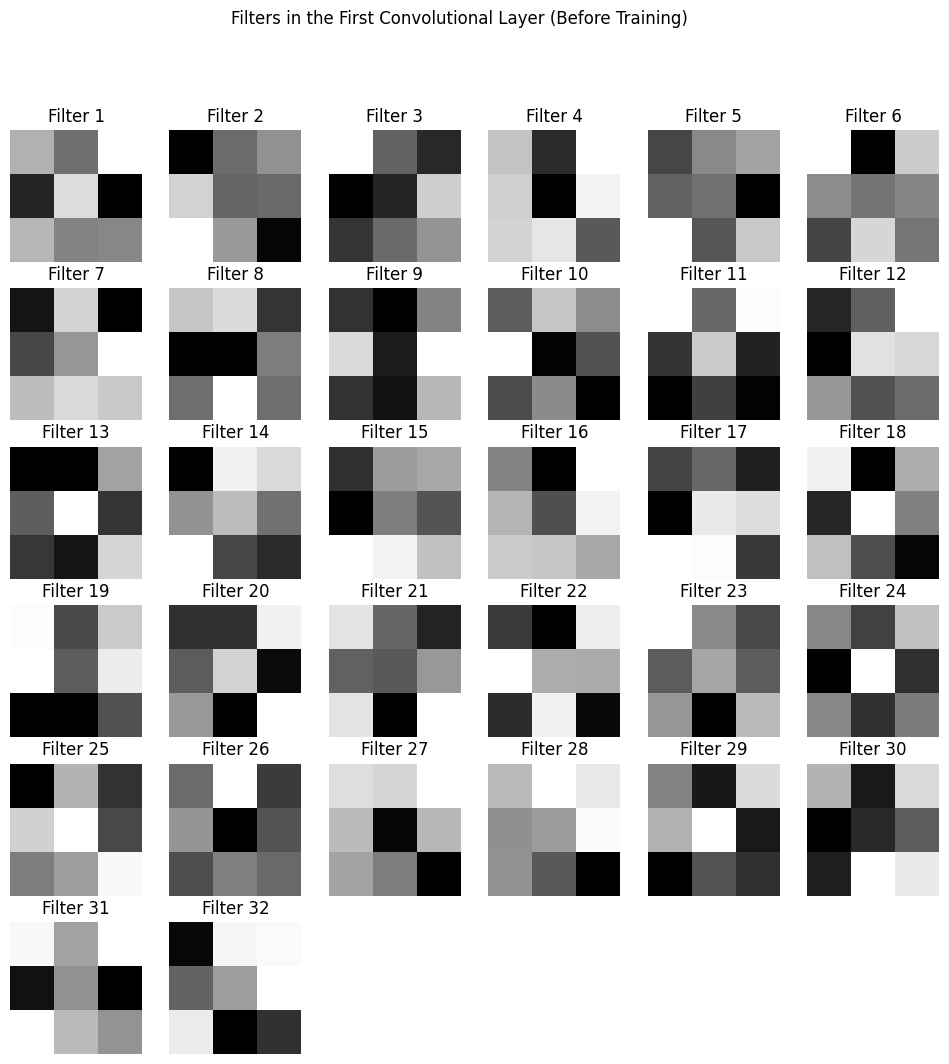

In [8]:
# Step 6: Filter Visualization (adapted from Visualising_CNN.ipynb)
# This section visualizes the filters learned by the first convolutional layer of your model.
# Note: For meaningful visualization, the model should ideally be trained.
# If run before training, these will be visualizations of randomly initialized filters.

# Get the first convolutional layer. Assuming it's the second layer in the sequential model
# (InputLayer is first, then Conv2D)
# You can inspect model.layers to confirm the index.
# For your model, model.layers[1] is the first Conv2D layer.
first_conv_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        first_conv_layer = layer
        break

if first_conv_layer:
    first_conv_layer_weights = first_conv_layer.get_weights()[0] # Weights are the first element

    # Normalize filter values for visualization (min-max scaling)
    min_val, max_val = first_conv_layer_weights.min(), first_conv_layer_weights.max()
    # Avoid division by zero if all weights are the same (e.g., all zeros)
    if (max_val - min_val) != 0:
        first_conv_layer_weights = (first_conv_layer_weights - min_val) / (max_val - min_val)
    else:
        # If all values are the same, make them 0 or 1 for visualization
        first_conv_layer_weights = np.zeros_like(first_conv_layer_weights) if min_val == 0 else np.ones_like(first_conv_layer_weights)


    # Plot the filters
    num_filters = first_conv_layer_weights.shape[3]
    # Calculate grid dimensions for plotting
    grid_size = int(np.ceil(np.sqrt(num_filters)))

    plt.figure(figsize=(grid_size * 2, grid_size * 2)) # Adjust figure size dynamically
    for i in range(num_filters):
        plt.subplot(grid_size, grid_size, i + 1)
        # For grayscale input, the filter will have shape (kernel_height, kernel_width, 1, num_filters)
        # We need to squeeze the channel dimension for imshow
        plt.imshow(first_conv_layer_weights[:, :, 0, i], cmap='gray') # Use 'gray' colormap for single channel
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle('Filters in the First Convolutional Layer (Before Training)')
    plt.show()
else:
    print("No Conv2D layer found in the model for filter visualization.")

In [10]:
# Step 7: Model Training (from model.ipynb)
print("\n[INFO] Training the model...")
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks= [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


[INFO] Training the model...
Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.6919 - loss: 0.7270 - val_accuracy: 0.7112 - val_loss: 0.7467
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 381ms/step - accuracy: 0.7176 - loss: 0.6608 - val_accuracy: 0.7685 - val_loss: 0.5884
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.7229 - loss: 0.6666 - val_accuracy: 0.7327 - val_loss: 0.6778
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.7483 - loss: 0.6085 - val_accuracy: 0.7470 - val_loss: 0.6838
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - accuracy: 0.7513 - loss: 0.6102 - val_accuracy: 0.7947 - val_loss: 0.5314
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 378ms/step - accuracy: 0.7861 - loss: 0.5537 - val_accuracy: 0.7924 - val_loss: 0.4995
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.7936 - loss: 0.5237 - val_accuracy: 0.7828 - val_loss: 0.5051
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 379ms/ste

In [11]:
# Step 8: Model Saving (from model.ipynb)
model.save('saved_model/medical_image_model.keras')
print("\nModel saved as 'medical_image_model.keras'")


Model saved as 'medical_image_model.keras'



[INFO] evaluating the model...
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step


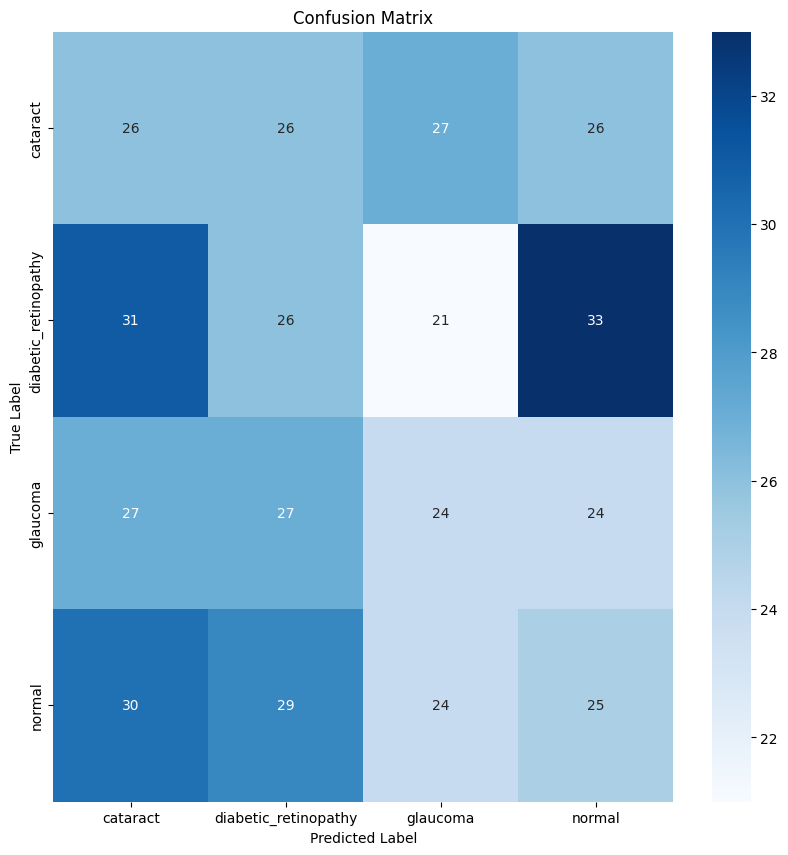


Classification Report:
                      precision    recall  f1-score   support

            cataract       0.23      0.25      0.24       105
diabetic_retinopathy       0.24      0.23      0.24       111
            glaucoma       0.25      0.24      0.24       102
              normal       0.23      0.23      0.23       108

            accuracy                           0.24       426
           macro avg       0.24      0.24      0.24       426
        weighted avg       0.24      0.24      0.24       426



In [12]:
# Step 9: Evaluation and Confusion Matrix (from model.ipynb)
print("\n[INFO] evaluating the model...")
test_gen.reset() # Reset the test generator to ensure evaluation starts from the beginning
predIdxs = model.predict(test_gen, steps = len(test_gen))
predIdxs = np.argmax(predIdxs, axis=1) # Get the predicted class indices

# Generate confusion matrix
matrix = confusion_matrix(test_gen.classes, predIdxs)
plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot=True, cbar=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
print("\nClassification Report:")
print(classification_report(test_gen.classes, predIdxs, target_names=class_names))